In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

np.random.seed(0)
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

from utils import (
    get_prepared_train_test,
    get_anomaly_detection_report,
    get_detection_score,
    get_best_score_threshold,
)

In [4]:
train_data_raw = pd.read_csv("../dataset/custom/features_fixed/wallets_features_with_users__train.csv")
test_data_raw = pd.read_csv("../dataset/custom/features_fixed/wallets_features_with_users__test.csv")

X_train, X_test, y_train, y_test = get_prepared_train_test(
    train_data_raw,
    test_data_raw,
)
X_train.shape, X_test.shape

((552376, 53), (281034, 53))

In [5]:
X_train_no_users = X_train.drop(columns=[
    'user_addr_cnt', 'user_outcoming_tx_cnt',
    'user_incoming_tx_cnt', 'user_input_users_cnt', 'user_output_users_cnt',
    'user_active_time_steps_cnt', 'user_btc_transacted_total',
    'user_btc_sent_total', 'user_btc_received_total',
    'user_btc_sent_median', 'user_btc_received_median',
    'user_interracted_output_address_cnt',
    'user_interracted_input_address_cnt', 'user_overall_activity_coef',
    'user_user_ts_fees_share_mean', 'user_user_ts_fees_share_min',
    'user_user_ts_fees_share_max', 'user_whole_fee_5',
])
X_test_no_users = X_test.drop(columns=[
    'user_addr_cnt', 'user_outcoming_tx_cnt',
    'user_incoming_tx_cnt', 'user_input_users_cnt', 'user_output_users_cnt',
    'user_active_time_steps_cnt', 'user_btc_transacted_total',
    'user_btc_sent_total', 'user_btc_received_total',
    'user_btc_sent_median', 'user_btc_received_median',
    'user_interracted_output_address_cnt',
    'user_interracted_input_address_cnt', 'user_overall_activity_coef',
    'user_user_ts_fees_share_mean', 'user_user_ts_fees_share_min',
    'user_user_ts_fees_share_max', 'user_whole_fee_5',
])

X_train_no_users.shape, X_test_no_users.shape

((552376, 35), (281034, 35))

In [6]:
X_train_licit = X_train.loc[train_data_raw["class"] == 2]

X_test_licit = X_test.loc[test_data_raw["class"] == 2]
X_test_illicit = X_test.loc[test_data_raw["class"] == 1]
X_test_unknown = X_test.loc[test_data_raw["class"] == 3]

X_train_licit.shape

(168269, 53)

In [7]:
(y_test == 1).sum() / y_test.shape[0]

0.01603008888604226

In [27]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(contamination=0.02, random_state=42)
model.fit(X_train)


IsolationForest(contamination=0.02, random_state=42)

In [31]:

# Predict: -1 for anomaly, 1 for normal
labels_illicit = model.predict(X_test_illicit)
labels_licit = model.predict(X_test_licit)
labels_unknown = model.predict(X_test_unknown)


# Anomaly score
scores_illicit = model.decision_function(X_test_illicit)
scores_licit = model.decision_function(X_test_licit)

In [32]:
get_anomaly_detection_report(
    labels_licit,
    labels_illicit,
    labels_unknown
)

Fraud wallets found pct: 0.003329633740288568
Licit wallets fraud pct: 0.13428635089653232
Licit wallets accuracy: 0.8657136491034677
Unknown wallets fraud pct: 0.003329633740288568
Unknown wallets accuracy: 0.9966703662597114

Total accuracy: 0.8307648250479938
Total precicion: 0.0013065064018813691
Total recall: 0.003329633740288568
Total illicit cnt: 11481 / 94283, true illicit: 4505


In [34]:
import optuna
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_samples = trial.suggest_float("max_samples", 0.1, 1.0)
    contamination = trial.suggest_float("contamination", 0.01, 0.2)
    max_features = trial.suggest_float("max_features", 0.5, 1.0)
    
    model = IsolationForest(
        n_estimators=n_estimators,
        max_samples=max_samples,
        contamination=contamination,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(X_train)

    labels_illicit = model.predict(X_test_illicit)
    labels_licit = model.predict(X_test_licit)
    labels_unknown = model.predict(X_test_unknown)

    score, prec, rec = get_detection_score(
        labels_licit,
        labels_illicit,
        labels_unknown
    )
    print(f"Precicion: {prec}, Recall: {rec}")
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best params:", study.best_params)
print("Best F1 Score:", study.best_value)

[I 2025-04-16 10:16:16,818] A new study created in memory with name: no-name-18a40117-d2bd-4d1a-a2a5-3146dc5c7d48
[I 2025-04-16 10:16:23,741] Trial 0 finished with value: 0.22044855255323373 and parameters: {'n_estimators': 231, 'max_samples': 0.11041921103584063, 'contamination': 0.0735815930672276, 'max_features': 0.8891178279535259}. Best is trial 0 with value: 0.22044855255323373.


Precicion: 0.05184543060047345, Recall: 0.34517203107658156


[I 2025-04-16 10:16:28,156] Trial 1 finished with value: 0.2163621372908854 and parameters: {'n_estimators': 142, 'max_samples': 0.2860866396198595, 'contamination': 0.11512938493124195, 'max_features': 0.7878381028834417}. Best is trial 0 with value: 0.22044855255323373.


Precicion: 0.046951201916140016, Recall: 0.3611542730299667


[I 2025-04-16 10:16:32,965] Trial 2 finished with value: 0.18724944603257837 and parameters: {'n_estimators': 132, 'max_samples': 0.9912041438001999, 'contamination': 0.014562387705107975, 'max_features': 0.8104840661479333}. Best is trial 0 with value: 0.22044855255323373.


Precicion: 0.059599440077527724, Recall: 0.24572697003329633


[I 2025-04-16 10:16:43,473] Trial 3 finished with value: 0.22304627727767745 and parameters: {'n_estimators': 295, 'max_samples': 0.9714279167593844, 'contamination': 0.08634366481804351, 'max_features': 0.8865925923721028}. Best is trial 3 with value: 0.22304627727767745.


Precicion: 0.05056882110263783, Recall: 0.35915649278579354


[I 2025-04-16 10:16:48,697] Trial 4 finished with value: 0.19213750850918992 and parameters: {'n_estimators': 194, 'max_samples': 0.2046481030605407, 'contamination': 0.018510512582069764, 'max_features': 0.6754836707583348}. Best is trial 3 with value: 0.22304627727767745.


Precicion: 0.06198188306340928, Recall: 0.2506104328523862


[I 2025-04-16 10:16:53,947] Trial 5 finished with value: 0.2247287020422114 and parameters: {'n_estimators': 148, 'max_samples': 0.5331961881152525, 'contamination': 0.06806945519707033, 'max_features': 0.9268196888793666}. Best is trial 5 with value: 0.2247287020422114.


Precicion: 0.05317965827519967, Recall: 0.35027746947835736


[I 2025-04-16 10:17:02,013] Trial 6 finished with value: 0.21353568070212098 and parameters: {'n_estimators': 252, 'max_samples': 0.43277059112401906, 'contamination': 0.14290087944804278, 'max_features': 0.8872485141302004}. Best is trial 5 with value: 0.2247287020422114.


Precicion: 0.04538766898925686, Recall: 0.36293007769145397


[I 2025-04-16 10:17:05,042] Trial 7 finished with value: 0.22853301966056125 and parameters: {'n_estimators': 116, 'max_samples': 0.18202555522650557, 'contamination': 0.14754381818110004, 'max_features': 0.5836366215193994}. Best is trial 7 with value: 0.22853301966056125.


Precicion: 0.04801999022217394, Recall: 0.39245283018867927


[I 2025-04-16 10:17:13,837] Trial 8 finished with value: 0.22926500337154418 and parameters: {'n_estimators': 296, 'max_samples': 0.49685990264079705, 'contamination': 0.06406757180443862, 'max_features': 0.59645134377127}. Best is trial 8 with value: 0.22926500337154418.


Precicion: 0.054808615722321305, Recall: 0.35471698113207545


[I 2025-04-16 10:17:16,704] Trial 9 finished with value: 0.20174004919683688 and parameters: {'n_estimators': 87, 'max_samples': 0.17314891240038974, 'contamination': 0.02486315057886638, 'max_features': 0.9452627219430294}. Best is trial 8 with value: 0.22926500337154418.


Precicion: 0.06101457958857599, Recall: 0.27125416204217534


[I 2025-04-16 10:17:18,508] Trial 10 finished with value: 0.25084214844187 and parameters: {'n_estimators': 57, 'max_samples': 0.7180948841893323, 'contamination': 0.19779480977955993, 'max_features': 0.5398336215033475}. Best is trial 10 with value: 0.25084214844187.


Precicion: 0.050571371291098635, Recall: 0.4479467258601554


[I 2025-04-16 10:17:20,108] Trial 11 finished with value: 0.2368517096867567 and parameters: {'n_estimators': 52, 'max_samples': 0.7612868041680511, 'contamination': 0.17816163106525423, 'max_features': 0.5040325773200949}. Best is trial 10 with value: 0.25084214844187.


Precicion: 0.04836305699748163, Recall: 0.41775804661487237


[I 2025-04-16 10:17:21,798] Trial 12 finished with value: 0.23332145008420715 and parameters: {'n_estimators': 53, 'max_samples': 0.7534541289762118, 'contamination': 0.1951772958881996, 'max_features': 0.5188455266329826}. Best is trial 10 with value: 0.25084214844187.


Precicion: 0.04651732758198127, Recall: 0.42130965593784686


[I 2025-04-16 10:17:23,422] Trial 13 finished with value: 0.23554498884776587 and parameters: {'n_estimators': 52, 'max_samples': 0.7361312840902354, 'contamination': 0.19202085473769603, 'max_features': 0.5033980657327034}. Best is trial 10 with value: 0.25084214844187.


Precicion: 0.04681752856064112, Recall: 0.42663706992230854


[I 2025-04-16 10:17:26,442] Trial 14 finished with value: 0.22522866824632476 and parameters: {'n_estimators': 92, 'max_samples': 0.7398249148000865, 'contamination': 0.1650906560447334, 'max_features': 0.682176934371023}. Best is trial 10 with value: 0.25084214844187.


Precicion: 0.046583932758938684, Recall: 0.39245283018867927


[I 2025-04-16 10:17:29,088] Trial 15 finished with value: 0.23387056409229692 and parameters: {'n_estimators': 85, 'max_samples': 0.6464937177797203, 'contamination': 0.17738660899798964, 'max_features': 0.5842869966264048}. Best is trial 10 with value: 0.25084214844187.


Precicion: 0.04747148916715349, Recall: 0.4148723640399556


[I 2025-04-16 10:17:34,697] Trial 16 finished with value: 0.2239341213972639 and parameters: {'n_estimators': 174, 'max_samples': 0.8619513221973795, 'contamination': 0.11943700566744296, 'max_features': 0.6776664161173749}. Best is trial 10 with value: 0.25084214844187.


Precicion: 0.048524967621240464, Recall: 0.3742508324084351


[I 2025-04-16 10:17:36,878] Trial 17 finished with value: 0.2232411593683159 and parameters: {'n_estimators': 70, 'max_samples': 0.6367004251695921, 'contamination': 0.15895624286482607, 'max_features': 0.5628282022022303}. Best is trial 10 with value: 0.25084214844187.


Precicion: 0.04644037088351274, Recall: 0.38690344062153165


[I 2025-04-16 10:17:40,574] Trial 18 finished with value: 0.24820530351125653 and parameters: {'n_estimators': 112, 'max_samples': 0.8382988681537685, 'contamination': 0.19773203575987142, 'max_features': 0.6366840143147638}. Best is trial 10 with value: 0.25084214844187.


Precicion: 0.0491502067064768, Recall: 0.45127635960044393


[I 2025-04-16 10:17:44,589] Trial 19 finished with value: 0.22103708351306484 and parameters: {'n_estimators': 122, 'max_samples': 0.8607980233472026, 'contamination': 0.13055770967240185, 'max_features': 0.6335670677323447}. Best is trial 10 with value: 0.25084214844187.


Precicion: 0.047027087157239, Recall: 0.3753607103218646


[I 2025-04-16 10:17:48,200] Trial 20 finished with value: 0.22628437566196902 and parameters: {'n_estimators': 105, 'max_samples': 0.8432122632852037, 'contamination': 0.1935264841272275, 'max_features': 0.7407629567372567}. Best is trial 10 with value: 0.25084214844187.


Precicion: 0.04573385715724791, Recall: 0.4031076581576027


[I 2025-04-16 10:17:50,441] Trial 21 finished with value: 0.22805743479978086 and parameters: {'n_estimators': 73, 'max_samples': 0.7840870940779058, 'contamination': 0.1682486722105976, 'max_features': 0.537565107492947}. Best is trial 10 with value: 0.25084214844187.


Precicion: 0.047174783892051445, Recall: 0.3973362930077691


[I 2025-04-16 10:17:52,134] Trial 22 finished with value: 0.2372805434931379 and parameters: {'n_estimators': 51, 'max_samples': 0.6433204840813271, 'contamination': 0.17938533096055984, 'max_features': 0.6228154649996647}. Best is trial 10 with value: 0.25084214844187.


Precicion: 0.047885697067095216, Recall: 0.42330743618202


[I 2025-04-16 10:17:57,348] Trial 23 finished with value: 0.24521747521289172 and parameters: {'n_estimators': 170, 'max_samples': 0.6183898844263982, 'contamination': 0.19932318655213915, 'max_features': 0.6313718712155484}. Best is trial 10 with value: 0.25084214844187.


Precicion: 0.047992257028870895, Recall: 0.45127635960044393


[I 2025-04-16 10:18:02,835] Trial 24 finished with value: 0.23562526119127805 and parameters: {'n_estimators': 186, 'max_samples': 0.39085333058915195, 'contamination': 0.19640644380292663, 'max_features': 0.7165743833299323}. Best is trial 10 with value: 0.25084214844187.


Precicion: 0.04697032808173866, Recall: 0.425527192008879


[I 2025-04-16 10:18:07,754] Trial 25 finished with value: 0.22074573836306965 and parameters: {'n_estimators': 161, 'max_samples': 0.5922543750703854, 'contamination': 0.1507989042809632, 'max_features': 0.6407786523325683}. Best is trial 10 with value: 0.25084214844187.


Precicion: 0.04599390667593137, Recall: 0.38201997780244173


[I 2025-04-16 10:18:14,161] Trial 26 finished with value: 0.23476935379079414 and parameters: {'n_estimators': 211, 'max_samples': 0.9080593579062739, 'contamination': 0.18015156145767675, 'max_features': 0.5479325052186872}. Best is trial 10 with value: 0.25084214844187.


Precicion: 0.04758046137094528, Recall: 0.41709211986681466


[I 2025-04-16 10:18:17,501] Trial 27 finished with value: 0.24572506541714842 and parameters: {'n_estimators': 107, 'max_samples': 0.6629433254012527, 'contamination': 0.1997068961858009, 'max_features': 0.6142813954913234}. Best is trial 10 with value: 0.25084214844187.


Precicion: 0.04851033157135992, Recall: 0.44816870144284127


[I 2025-04-16 10:18:20,887] Trial 28 finished with value: 0.230024022986701 and parameters: {'n_estimators': 105, 'max_samples': 0.6805624422678112, 'contamination': 0.04021139236690206, 'max_features': 0.7139537431611052}. Best is trial 10 with value: 0.25084214844187.


Precicion: 0.06329934324230903, Recall: 0.32519422863485015


[I 2025-04-16 10:18:23,405] Trial 29 finished with value: 0.22235634627782883 and parameters: {'n_estimators': 74, 'max_samples': 0.8212205796554828, 'contamination': 0.10162517517690595, 'max_features': 0.7834400079251317}. Best is trial 10 with value: 0.25084214844187.


Precicion: 0.050098899740388184, Recall: 0.3598224195338513


[I 2025-04-16 10:18:26,573] Trial 30 finished with value: 0.21344758878455988 and parameters: {'n_estimators': 100, 'max_samples': 0.7028283095976731, 'contamination': 0.13852760530481234, 'max_features': 0.6124953703314844}. Best is trial 10 with value: 0.25084214844187.


Precicion: 0.04522377352243254, Recall: 0.36381798002219756


[I 2025-04-16 10:18:33,735] Trial 31 finished with value: 0.23730711796913886 and parameters: {'n_estimators': 232, 'max_samples': 0.5829600553943007, 'contamination': 0.19912089146988443, 'max_features': 0.6523246246474383}. Best is trial 10 with value: 0.25084214844187.


Precicion: 0.047896521411528316, Recall: 0.42330743618202


[I 2025-04-16 10:18:37,979] Trial 32 finished with value: 0.22571785268414482 and parameters: {'n_estimators': 150, 'max_samples': 0.4665112966455443, 'contamination': 0.18458653895606136, 'max_features': 0.5616092300038679}. Best is trial 10 with value: 0.25084214844187.


Precicion: 0.04570850714195424, Recall: 0.40133185349611544


[I 2025-04-16 10:18:42,406] Trial 33 finished with value: 0.21638743655306644 and parameters: {'n_estimators': 127, 'max_samples': 0.8972527001192577, 'contamination': 0.16761501023857342, 'max_features': 0.8342969304952254}. Best is trial 10 with value: 0.25084214844187.


Precicion: 0.04468789407313997, Recall: 0.37758046614872365


[I 2025-04-16 10:18:46,521] Trial 34 finished with value: 0.22314974290635253 and parameters: {'n_estimators': 141, 'max_samples': 0.3583148691716641, 'contamination': 0.18752577823595815, 'max_features': 0.5931237557213769}. Best is trial 10 with value: 0.25084214844187.


Precicion: 0.045515154623314014, Recall: 0.3940066592674806


[I 2025-04-16 10:18:51,923] Trial 35 finished with value: 0.2275452189719855 and parameters: {'n_estimators': 163, 'max_samples': 0.9399882655349314, 'contamination': 0.15748215810329272, 'max_features': 0.6610580465375964}. Best is trial 10 with value: 0.25084214844187.


Precicion: 0.04767435578845011, Recall: 0.39178690344062156


[I 2025-04-16 10:19:00,410] Trial 36 finished with value: 0.23637557452396585 and parameters: {'n_estimators': 270, 'max_samples': 0.5293295207048913, 'contamination': 0.17392828982277467, 'max_features': 0.7035451324791961}. Best is trial 10 with value: 0.25084214844187.


Precicion: 0.04843341698791752, Recall: 0.4155382907880133


[I 2025-04-16 10:19:06,499] Trial 37 finished with value: 0.2228427582981416 and parameters: {'n_estimators': 205, 'max_samples': 0.575352750682842, 'contamination': 0.09012887355473237, 'max_features': 0.5348912134617468}. Best is trial 10 with value: 0.25084214844187.


Precicion: 0.05038566807663598, Recall: 0.35960044395116536


[I 2025-04-16 10:19:11,035] Trial 38 finished with value: 0.2480930163667333 and parameters: {'n_estimators': 135, 'max_samples': 0.6788631253646165, 'contamination': 0.1882746250705931, 'max_features': 0.7697505980145345}. Best is trial 10 with value: 0.25084214844187.


Precicion: 0.04966273812171077, Recall: 0.44617092119866814


[I 2025-04-16 10:19:15,911] Trial 39 finished with value: 0.23040099471557351 and parameters: {'n_estimators': 133, 'max_samples': 0.709731583864531, 'contamination': 0.18813543871608607, 'max_features': 0.8488700356111569}. Best is trial 10 with value: 0.25084214844187.


Precicion: 0.04646439317953861, Recall: 0.41132075471698115


[I 2025-04-16 10:19:19,776] Trial 40 finished with value: 0.2189489419830408 and parameters: {'n_estimators': 111, 'max_samples': 0.7834889087436593, 'contamination': 0.1567417885647827, 'max_features': 0.7717517220426918}. Best is trial 10 with value: 0.25084214844187.


Precicion: 0.045853237254743204, Recall: 0.3771365149833518


[I 2025-04-16 10:19:25,164] Trial 41 finished with value: 0.2369452739986973 and parameters: {'n_estimators': 160, 'max_samples': 0.6309553634631012, 'contamination': 0.19992259160631776, 'max_features': 0.7465988094459609}. Best is trial 10 with value: 0.25084214844187.


Precicion: 0.04722712130119538, Recall: 0.42796892341842396


[I 2025-04-16 10:19:31,120] Trial 42 finished with value: 0.23487295905003056 and parameters: {'n_estimators': 177, 'max_samples': 0.6835757347539153, 'contamination': 0.18801113293007704, 'max_features': 0.8064645698979364}. Best is trial 10 with value: 0.25084214844187.


Precicion: 0.04751930550648564, Recall: 0.41798002219755825


[I 2025-04-16 10:19:35,974] Trial 43 finished with value: 0.22365993580833482 and parameters: {'n_estimators': 143, 'max_samples': 0.9909409793539925, 'contamination': 0.17246699001178015, 'max_features': 0.60668942580562}. Best is trial 10 with value: 0.25084214844187.


Precicion: 0.04586323944756821, Recall: 0.39289678135405104


[I 2025-04-16 10:19:39,708] Trial 44 finished with value: 0.2489037273270879 and parameters: {'n_estimators': 120, 'max_samples': 0.5431439870281182, 'contamination': 0.1869350895672542, 'max_features': 0.5774820484037287}. Best is trial 10 with value: 0.25084214844187.


Precicion: 0.05029325144108541, Recall: 0.4435072142064373


[I 2025-04-16 10:19:43,286] Trial 45 finished with value: 0.2367662165674468 and parameters: {'n_estimators': 120, 'max_samples': 0.5206713691809776, 'contamination': 0.1887925023190392, 'max_features': 0.5658475028461973}. Best is trial 10 with value: 0.25084214844187.


Precicion: 0.0475255887906191, Recall: 0.4246392896781354


[I 2025-04-16 10:19:46,191] Trial 46 finished with value: 0.22572316639093598 and parameters: {'n_estimators': 96, 'max_samples': 0.8040327309390561, 'contamination': 0.18204002884976664, 'max_features': 0.5229165743976698}. Best is trial 10 with value: 0.25084214844187.


Precicion: 0.0458935351527661, Recall: 0.3997780244173141


[I 2025-04-16 10:19:48,770] Trial 47 finished with value: 0.22422266928111234 and parameters: {'n_estimators': 85, 'max_samples': 0.48081743636792096, 'contamination': 0.16239290029097803, 'max_features': 0.578446872360035}. Best is trial 10 with value: 0.25084214844187.


Precicion: 0.0463506435395994, Recall: 0.3908990011098779


[I 2025-04-16 10:19:51,149] Trial 48 finished with value: 0.22888723455263524 and parameters: {'n_estimators': 67, 'max_samples': 0.42772599348174584, 'contamination': 0.1727726452433573, 'max_features': 0.9922752402169408}. Best is trial 10 with value: 0.25084214844187.


Precicion: 0.0468636974268885, Recall: 0.40266370699223086


[I 2025-04-16 10:19:55,583] Trial 49 finished with value: 0.234453881332779 and parameters: {'n_estimators': 132, 'max_samples': 0.7235002705015132, 'contamination': 0.05554932151240687, 'max_features': 0.8621805776450321}. Best is trial 10 with value: 0.25084214844187.


Precicion: 0.05891131589747416, Recall: 0.3504994450610433
Best params: {'n_estimators': 57, 'max_samples': 0.7180948841893323, 'contamination': 0.19779480977955993, 'max_features': 0.5398336215033475}
Best F1 Score: 0.25084214844187


In [9]:
from sklearn.ensemble import IsolationForest

best_params = {'n_estimators': 57, 'max_samples': 0.7180948841893323, 'contamination': 0.19779480977955993, 'max_features': 0.5398336215033475}

model = IsolationForest(**best_params)
model.fit(X_train)


IsolationForest(contamination=0.19779480977955993,
                max_features=0.5398336215033475, max_samples=0.7180948841893323,
                n_estimators=57)

	real 1	real 0
pred 1	1967	153053	
pred 0	2538	123476	
[0.01603008888604226, 0.01603008888604226, 0.01603008888604226, 0.01603008888604226, 0.01603008888604226, 0.01603008888604226, 0.01603008888604226, 0.01603008888604226, 0.01603008888604226, 0.01603008888604226, 0.01603008888604226, 0.01603014592592329, 0.016031400906014355, 0.016044247220303006, 0.01610377351744456, 0.016265156003873002, 0.016432886630960274, 0.014808007723894052, 0.01382403354196827, 0.014160754060153703, 0.012658850133962589, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


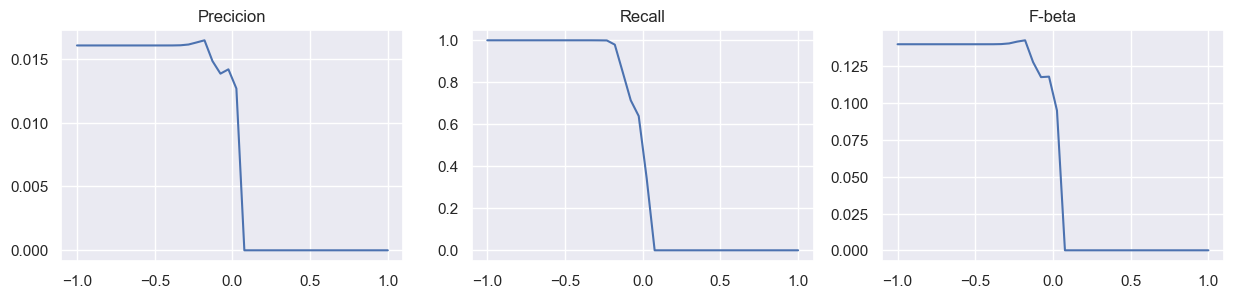

In [19]:
get_best_score_threshold(
    model.decision_function(X_test_licit),
    model.decision_function(X_test_illicit),
    model.decision_function(X_test_unknown)
)

In [21]:
(1967+123476)/(1967+123476+2538+153053)

0.44636236184945594